In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import KMeans

Mounted at /content/drive
Dataset Shape: (1800, 9)

Features and Data Types:
 Age                          int64
BMI                        float64
Blood_Pressure               int64
Cholesterol                float64
Heart_Rate                   int64
Smoking_Habit               object
Physical_Activity_Level     object
Family_History              object
Disease_Type                object
dtype: object

Unique classes in Disease_Type:
 Disease_Type
Type B    634
Type A    589
Type C    577
Name: count, dtype: int64


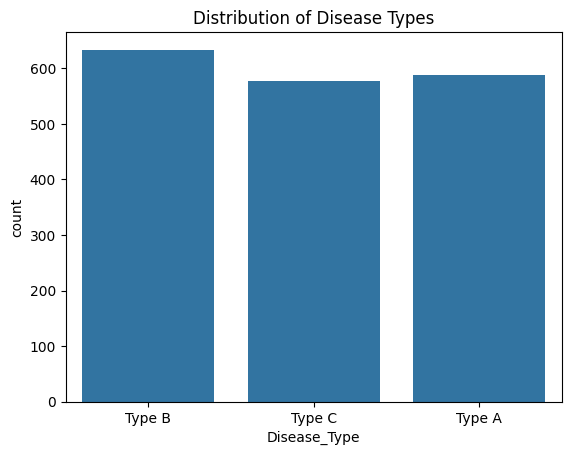

In [2]:
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/disease_classification_dataset - disease_classification_dataset.csv")


print("Dataset Shape:", df.shape)
print("\nFeatures and Data Types:\n", df.dtypes)
print("\nUnique classes in Disease_Type:\n", df['Disease_Type'].value_counts())

sns.countplot(x='Disease_Type', data=df)
plt.title('Distribution of Disease Types')
plt.show()

In [3]:
df.shape

(1800, 9)

In [4]:
df.head()

,Age,BMI,Blood_Pressure,Cholesterol,Heart_Rate,Smoking_Habit,Physical_Activity_Level,Family_History,Disease_Type
0,51,29.317228,155,285.0,104,Non-Smoker,High,No,Type B
1,25,32.918835,117,150.0,85,Non-Smoker,Low,No,Type C
2,41,23.079369,140,208.0,118,Non-Smoker,Low,No,Type C
3,30,37.053188,128,184.0,65,Smoker,Moderate,Yes,Type C
4,68,29.756353,102,165.0,102,Smoker,Low,Yes,Type A


In [5]:
df.describe()

,Age,BMI,Blood_Pressure,Cholesterol,Heart_Rate
count,1800.000000,1710.000000,1800.0000,1710.000000,1800.000000
mean,49.141667,25.107380,118.6700,223.366667,89.656667
std,17.397342,4.922958,22.8943,43.664348,17.073979
min,20.000000,7.463003,80.0000,150.000000,60.000000
25%,34.000000,21.802118,99.0000,185.000000,75.000000
50%,49.000000,25.124630,118.0000,223.500000,90.000000
75%,64.000000,28.401955,137.2500,260.000000,104.000000
max,79.000000,41.767133,159.0000,299.000000,119.000000


In [6]:
df.isnull().sum()

,0
Age,0
BMI,90
Blood_Pressure,0
Cholesterol,90
Heart_Rate,0
Smoking_Habit,90
Physical_Activity_Level,0
Family_History,0
Disease_Type,0


In [7]:
df.nunique().sort_values()

,0
Family_History,2
Smoking_Habit,2
Physical_Activity_Level,3
Disease_Type,3
Heart_Rate,60
Age,60
Blood_Pressure,80
Cholesterol,150
BMI,1710


In [8]:
df.dtypes.value_counts()

,count
object,4
int64,3
float64,2


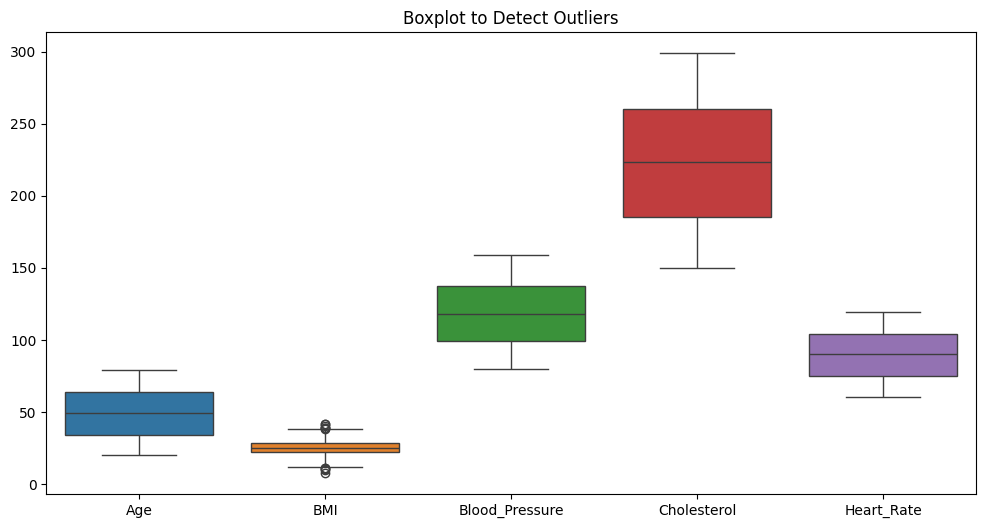

In [9]:

num_cols = ['Age', 'BMI', 'Blood_Pressure', 'Cholesterol', 'Heart_Rate']


plt.figure(figsize=(12, 6))
sns.boxplot(data=df[num_cols])
plt.title("Boxplot to Detect Outliers")
plt.show()

# **Correlation Matrix**

                     Age       BMI  Blood_Pressure  Cholesterol  Heart_Rate
Age             1.000000  0.031719       -0.004336     0.011312   -0.017017
BMI             0.031719  1.000000       -0.006668     0.014269   -0.000168
Blood_Pressure -0.004336 -0.006668        1.000000    -0.022515    0.003458
Cholesterol     0.011312  0.014269       -0.022515     1.000000   -0.018793
Heart_Rate     -0.017017 -0.000168        0.003458    -0.018793    1.000000


<Figure size 800x600 with 0 Axes>

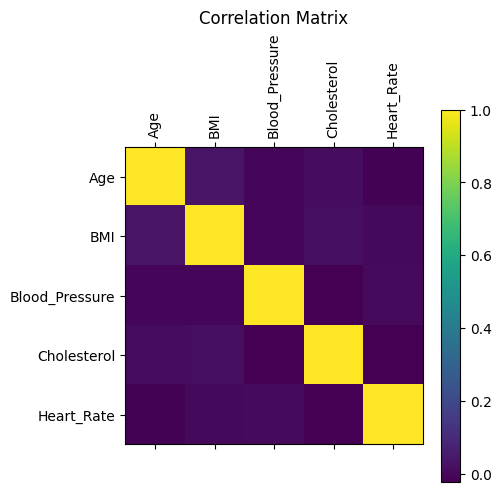

In [10]:
plt.figure(figsize=(8, 6))
correlation_matrix = df.corr(numeric_only=True)
print(correlation_matrix)
plt.matshow(correlation_matrix)
plt.title('Correlation Matrix')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()
plt.show()

# **`Data Preprocessing`**

# **Missing value handling**

In [11]:
df['BMI'] = df['BMI'].fillna(df['BMI'].median())
df['Cholesterol'] = df['Cholesterol'].fillna(df['Cholesterol'].median())
df['Smoking_Habit'] = df['Smoking_Habit'].fillna(df['Smoking_Habit'].mode()[0])
df['Family_History'] = df['Family_History'].fillna(df['Family_History'].mode()[0])
print("Missing values after imputation:\n", df.isnull().sum())

def remove_outliers(data, columns):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

numerical_cols = ['BMI', 'Blood_Pressure', 'Cholesterol', 'Heart_Rate']
df_cleaned = remove_outliers(df.copy(), numerical_cols)
print(f"Rows after outlier removal: {df_cleaned.shape[0]}")

Missing values after imputation:
 Age                        0
BMI                        0
Blood_Pressure             0
Cholesterol                0
Heart_Rate                 0
Smoking_Habit              0
Physical_Activity_Level    0
Family_History             0
Disease_Type               0
dtype: int64
Rows after outlier removal: 1782


# **Encoding for categorical values**

In [12]:
#one hot encoding
df_final = pd.get_dummies(df_cleaned,
    columns=['Smoking_Habit', 'Physical_Activity_Level', 'Family_History'],
        drop_first=True)
#label encoding
le = LabelEncoder()
df_final['Disease_Type'] = le.fit_transform(df_final['Disease_Type'])
print(df_final)

      Age        BMI  Blood_Pressure  Cholesterol  Heart_Rate  Disease_Type  \
0      51  29.317228             155        285.0         104             1   
1      25  32.918835             117        150.0          85             2   
2      41  23.079369             140        208.0         118             2   
3      30  37.053188             128        184.0          65             2   
4      68  29.756353             102        165.0         102             0   
...   ...        ...             ...          ...         ...           ...   
1795   43  22.096224             132        240.0          73             1   
1796   40  20.266446             143        160.0          78             2   
1797   76  26.382593             112        167.0         101             1   
1798   28  24.695178             117        230.0          83             2   
1799   38  21.140013             158        247.0         113             1   

      Smoking_Habit_Smoker  Physical_Activity_Level

# **Dataset Splitting**

In [13]:

X = df_final.drop('Disease_Type', axis=1)
y = df_final['Disease_Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"\nClass distribution in training set:\n{pd.Series(y_train).value_counts()}")

Training set: (1425, 9)
Test set: (357, 9)

Class distribution in training set:
Disease_Type
1    502
0    467
2    456
Name: count, dtype: int64


# **Models**

In [14]:
#Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_scaled, y_train)

dt_pred = dt.predict(X_test_scaled)
print(f"Decision Tree Accuracy: {dt.score(X_test_scaled, y_test):.4f}")

Decision Tree Accuracy: 0.3529


In [15]:
#Logistic Regression
lr = LogisticRegression(max_iter=2000, multi_class='multinomial')
lr.fit(X_train_scaled, y_train)

lr_pred = lr.predict(X_test_scaled)
print(f"Logistic Regression Accuracy: {lr.score(X_test_scaled, y_test):.4f}")

Logistic Regression Accuracy: 0.3697


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [16]:
#Neural Network MLP
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=2000, random_state=42)
mlp.fit(X_train_scaled, y_train)

mlp_pred = mlp.predict(X_test_scaled)
print(f"Neural Network Accuracy: {mlp.score(X_test_scaled, y_test):.4f}")

Neural Network Accuracy: 0.3613


In [17]:
#Naive Bayes
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

nb_pred = nb.predict(X_test_scaled)
print(f"Naive Bayes Accuracy: {nb.score(X_test_scaled, y_test):.4f}")

Naive Bayes Accuracy: 0.3557


In [18]:
#KNN
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train)

knn_pred = knn.predict(X_test_scaled)
print(f"KNN Accuracy: {knn.score(X_test_scaled, y_test):.4f}")

KNN Accuracy: 0.3193


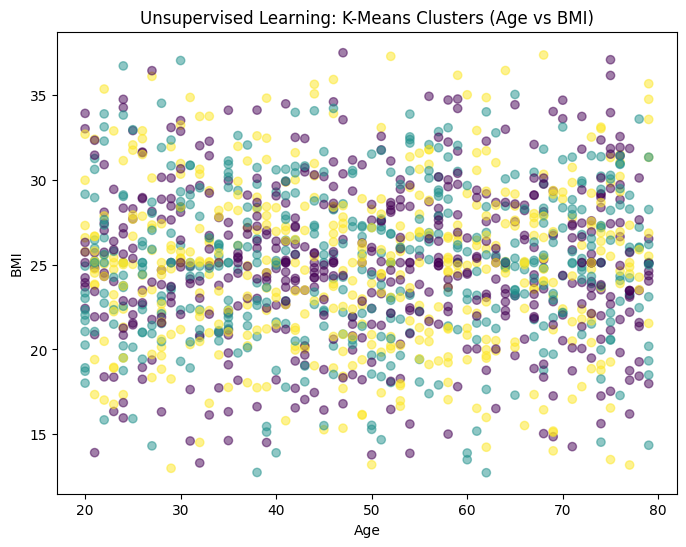

In [19]:
#Unsupervised
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_train_scaled)


plt.figure(figsize=(8, 6))
plt.scatter(X_train['Age'], X_train['BMI'], c=clusters, cmap='viridis', alpha=0.5)
plt.title('Unsupervised Learning: K-Means Clusters (Age vs BMI)')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()

# **Model Selection/Comparison Analysis**

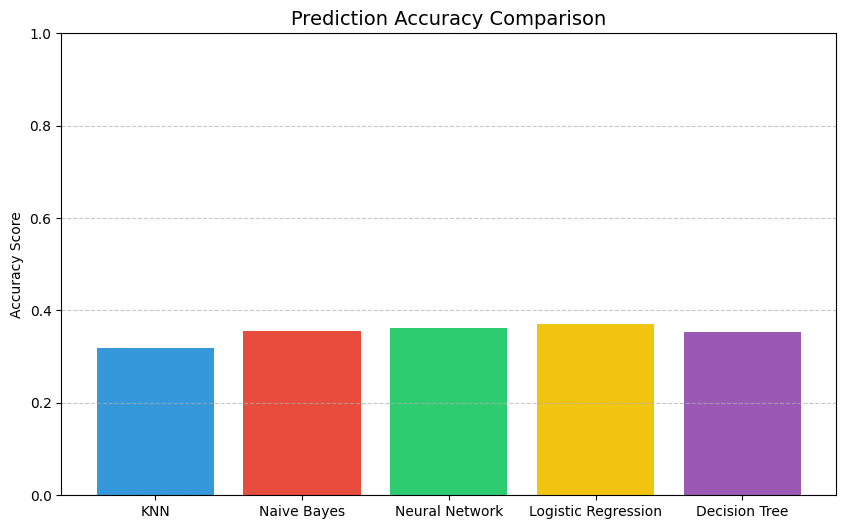

In [20]:
acc_scores = {
    'KNN': accuracy_score(y_test, knn_pred),
    'Naive Bayes': accuracy_score(y_test, nb_pred),
    'Neural Network': accuracy_score(y_test, mlp_pred),
    'Logistic Regression': accuracy_score(y_test, lr_pred),
    'Decision Tree': accuracy_score(y_test, dt_pred)
}


df_acc = pd.DataFrame(list(acc_scores.items()), columns=['Model', 'Accuracy'])


plt.figure(figsize=(10, 6))
plt.bar(df_acc['Model'], df_acc['Accuracy'], color=['#3498db', '#e74c3c', '#2ecc71', '#f1c40f', '#9b59b6'])
plt.ylim(0, 1.0)
plt.title('Prediction Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

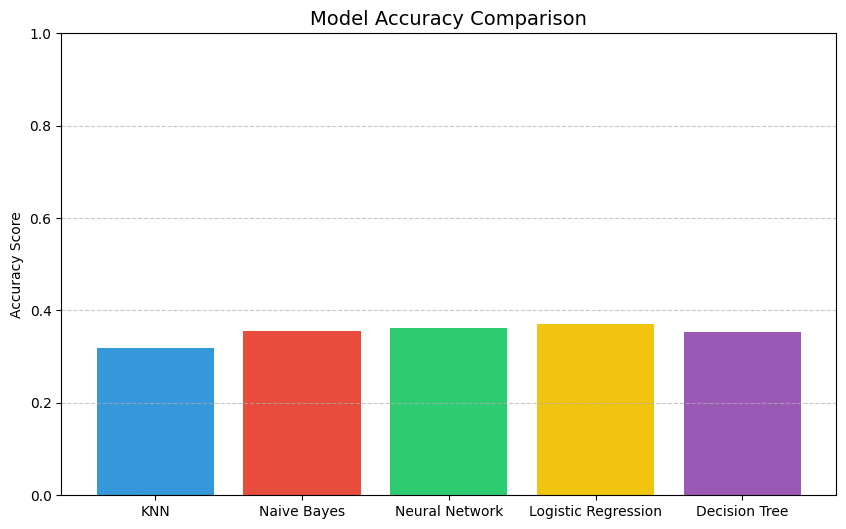

In [21]:
predictions = {
    'KNN': knn_pred,
    'Naive Bayes': nb_pred,
    'Neural Network': mlp_pred,
    'Logistic Regression': lr_pred,
    'Decision Tree': dt_pred
}


acc_results = {name: accuracy_score(y_test, pred) for name, pred in predictions.items()}
df_acc = pd.DataFrame(list(acc_results.items()), columns=['Model', 'Accuracy'])


plt.figure(figsize=(10, 6))
plt.bar(df_acc['Model'], df_acc['Accuracy'], color=['#3498db', '#e74c3c', '#2ecc71', '#f1c40f', '#9b59b6'])
plt.ylim(0, 1.0)
plt.title('Model Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

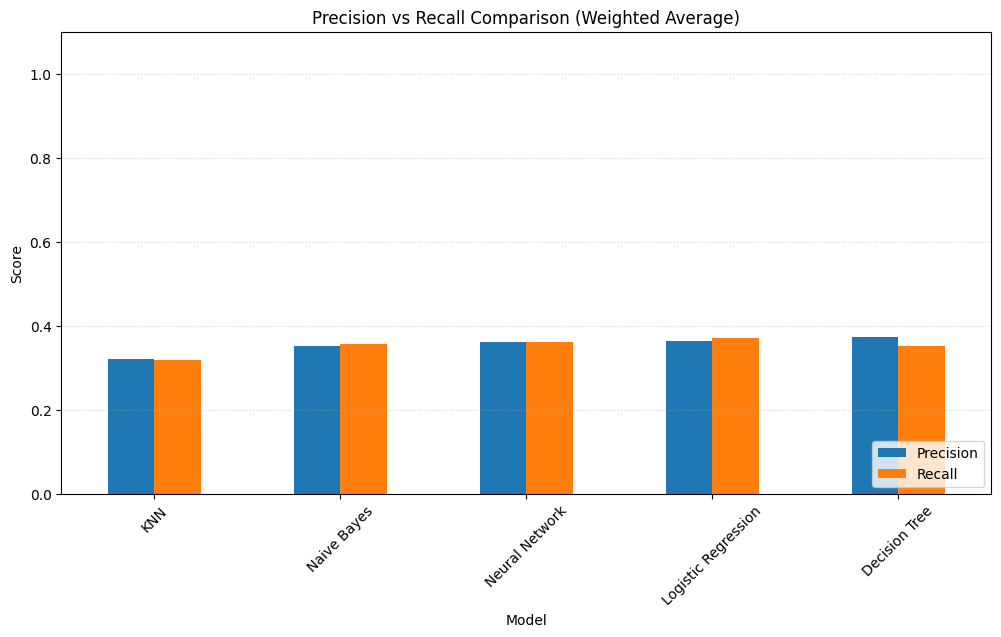

In [22]:

metrics_list = []
for name, pred in predictions.items():
    metrics_list.append({
        'Model': name,
        'Precision': precision_score(y_test, pred, average='weighted'),
        'Recall': recall_score(y_test, pred, average='weighted')
    })

df_metrics = pd.DataFrame(metrics_list)

df_metrics.set_index('Model').plot(kind='bar', figsize=(12, 6))
plt.title('Precision vs Recall Comparison (Weighted Average)')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()

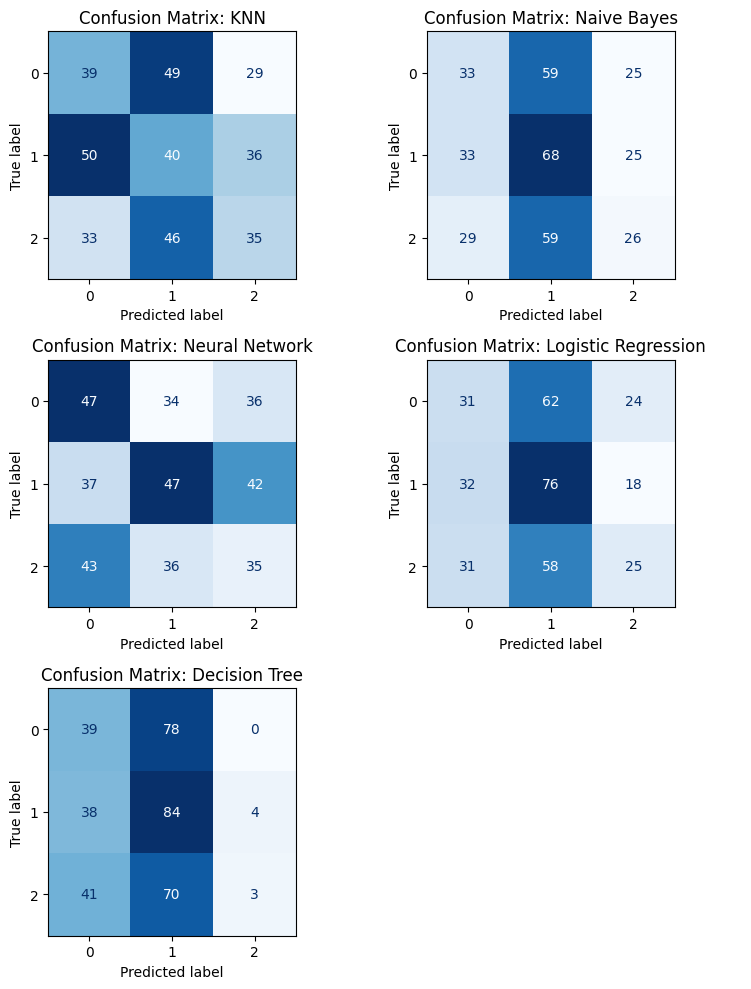

In [23]:

model_objects = [
    ('KNN', knn),
    ('Naive Bayes', nb),
    ('Neural Network', mlp),
    ('Logistic Regression', lr),
    ('Decision Tree', dt)
]

fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes = axes.flatten()

for i, (name, model) in enumerate(model_objects):
    ConfusionMatrixDisplay.from_estimator(
        model, X_test_scaled, y_test,
        ax=axes[i], cmap='Blues', colorbar=False
    )
    axes[i].set_title(f'Confusion Matrix: {name}')


axes[-1].axis('off')

plt.tight_layout()
plt.show()

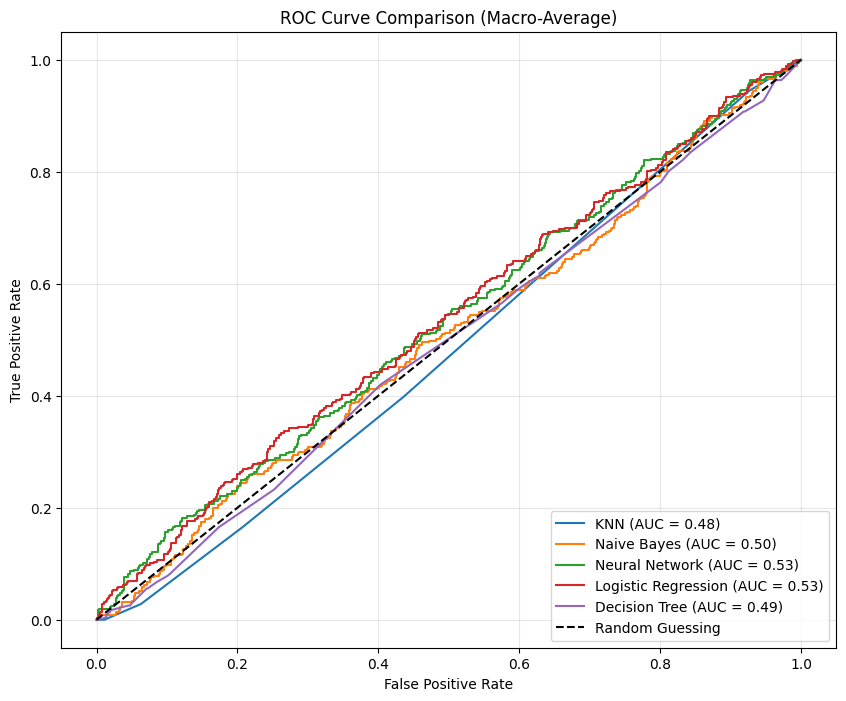

In [24]:

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))

for name, model in model_objects:
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)
    else:
        y_score = model.decision_function(X_test_scaled)

    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Macro-Average)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()